# Week 6-1: Election Prediction through simulation

This is the first of two classes on election prediction. We'll be using simulation throughout to build our model.

All data is downloaded from [Huffington Post Pollster](http://elections.huffingtonpost.com/pollster#historical-charts)

Further references for your enjoyment:

- [The Real Story of 2016](https://fivethirtyeight.com/features/the-real-story-of-2016/) - Fivethirtyeight
- Buzzfeed's post-election [forecast grades](https://www.buzzfeednews.com/article/jsvine/2016-election-forecast-grades)
- [Putting the Polling Miss of the 2016 Election in Perspective](https://www.nytimes.com/interactive/2016/11/13/upshot/putting-the-polling-miss-of-2016-in-perspective.html) - The Upshot
- [After 2016, Can We Ever Trust the Polls Again?](https://newrepublic.com/article/139158/2016-can-ever-trust-polls-again) - The New Republic 

And finally, the single biggest reason that the simple election prediction model in this file misses so badly (predicting Clinton's chances in the high 90s): it does not take into account the [correlations between polling errors](https://www.quantamagazine.org/why-nate-silver-sam-wang-and-everyone-else-were-wrong-part-2-20161111/) in different states. If we fix this one factor, even our simple model will give Trump substantially higher chances.

To see what goes into a much more realistic election model, check out this [notebook recreation of 538's 2012 model](http://nbviewer.jupyter.org/github/jseabold/538model/blob/master/silver_model.ipynb) by by Skipper Seabold.

## Part 1: Simulating one poll

Here we'll produce simulated election outcomes from a single poll. We are uncritically taking the poll results as an unbiased inidicator of results. This assumes that the people who are polled ("likely voters") are a good representation of the people who actually vote. It is possible to adjust these sorts of factors later, but let's begin with the basics.

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Set a random seed so this whole notebook becomes deterministic (for teaching purposes)
np.random.seed(999)

In [3]:
# Load national polling data. It's a TSV file, so we have to tell read_csv it's separated by tabs
uspolls = pd.read_csv('data/US.tsv', sep='\t')
uspolls.head()

,Trump,Clinton,Johnson,Other,Undecided,poll_slug,survey_house,start_date,end_date,question_text,sample_subpopulation,observations,margin_of_error,mode,partisanship,partisan_affiliation
0,41.0,45.0,4.0,2.0,8.0,insights-west-26812,Insights West,2016-11-04,2016-11-07,"As you may know, there will be a presidential ...",Likely Voters,940.0,3.2,Internet,Nonpartisan,None
1,6.0,89.0,1.0,0.0,4.0,insights-west-26812,Insights West,2016-11-04,2016-11-07,"As you may know, there will be a presidential ...",Likely Voters - Democrat,NaN,NaN,Internet,Nonpartisan,None
2,82.0,7.0,3.0,2.0,6.0,insights-west-26812,Insights West,2016-11-04,2016-11-07,"As you may know, there will be a presidential ...",Likely Voters - Republican,NaN,NaN,Internet,Nonpartisan,None
3,38.0,43.0,8.0,4.0,7.0,insights-west-26812,Insights West,2016-11-04,2016-11-07,"As you may know, there will be a presidential ...",Likely Voters - independent,NaN,NaN,Internet,Nonpartisan,None
4,43.0,41.0,7.0,4.0,5.0,ibd-tipp-26811,IBD/TIPP,2016-11-04,2016-11-07,NaN,Likely Voters,1107.0,3.1,Live Phone,Nonpartisan,None


In [4]:
# keep only polls of "likely voters" (as opposed to registered voters, or republicans/democracts)
uspolls = uspolls[uspolls.sample_subpopulation == 'Likely Voters']
len(uspolls)

513

In [5]:
# We need a margin of error to do our simulation, so drop any rows that don't have it
uspolls=uspolls[~pd.isnull(uspolls.margin_of_error)].reset_index(drop=True)
len(uspolls)

388

There are lot of polls here! Let's pick just one, near the end of the polling period (just before the election) and look at the outcomes it implies.

In [6]:
uspolls.tail()

,Trump,Clinton,Johnson,Other,Undecided,poll_slug,survey_house,start_date,end_date,question_text,sample_subpopulation,observations,margin_of_error,mode,partisanship,partisan_affiliation
383,47.0,43.0,NaN,NaN,11.0,emerson-college-polling-society-22699,Emerson College Polling Society,2015-09-05,2015-09-08,NaN,Likely Voters,955.0,3.1,Automated Phone,Nonpartisan,None
384,44.0,46.0,NaN,NaN,11.0,ppp-d-22654,PPP (D),2015-08-28,2015-08-30,NaN,Likely Voters,1254.0,2.8,IVR/Online,Pollster,Dem
385,40.0,49.0,NaN,NaN,12.0,emerson-college-polling-society-22537,Emerson College Polling Society,2015-07-26,2015-07-28,NaN,Likely Voters,950.0,3.4,Automated Phone,Nonpartisan,None
386,37.0,50.0,NaN,NaN,13.0,ppp-d-22415,PPP (D),2015-07-20,2015-07-21,NaN,Likely Voters,1087.0,3.0,IVR/Online,Pollster,Dem
387,34.0,51.0,NaN,NaN,16.0,suffolk-usa-today-22380,Suffolk/USA Today,2015-07-09,2015-07-12,NaN,Likely Voters,1000.0,3.0,Live Phone,Nonpartisan,None


We will pick a poll which showed a close race, because it better demonstrates how the margin of error works.

In [7]:
poll = uspolls.iloc[384]
poll

Trump                              44
Clinton                            46
Johnson                           NaN
Other                             NaN
Undecided                          11
poll_slug                 ppp-d-22654
survey_house                  PPP (D)
start_date                 2015-08-28
end_date                   2015-08-30
question_text                     NaN
sample_subpopulation    Likely Voters
observations                     1254
margin_of_error                   2.8
mode                       IVR/Online
partisanship                 Pollster
partisan_affiliation              Dem
Name: 384, dtype: object

The poll results and the margin of error define a probability distribution of "true" survey results -- that is, the result that the pollster would get if they could ask every single "likely voter" in the country. This distribution is a "normal" distribution.

In [8]:
# We reduce the problem to the difference between the two poll results, because that's what actually matters
mean = 3

# Some subtlety in calculating the stddev from the margin of error (MOE)
#  - MOE is reported as 95% width, so we'd normally divide by 1.96 for standard deviation
#  - But we want the stddev for a difference between two poll questions which are not independent.
#    One more vote for Clinton is (almost always) one less vote for Trump. We need to multiply by nearly 2.
#  - These almost perfectly cancel out, and stddev of the difference is near exactly MOE
# See http://abcnews.go.com/images/PollingUnit/MOEFranklin.pdf
stddev = poll.margin_of_error

# For more general discussion of the MOE see 
# http://www.pewresearch.org/fact-tank/2016/09/08/understanding-the-margin-of-error-in-election-polls/


Now we can take samples from a normal distribution with this mean and standard deviation, to simulate what the underlying "true" voting pattern would be. For example,

In [9]:
np.random.normal(mean, stddev)

3.356041963171183

To interpret this number, recall that we're simulating the Clinton-Trump difference. So positive means it goes for Clinton, who our poll says is ahead 46-44. Given this, we would expect more of the simulation results to go for Clinton. Let's make 1000 and see what happens.

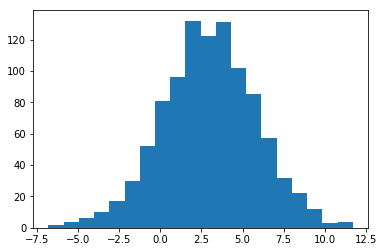

In [10]:
plt.hist(np.random.normal(mean, stddev, 1000), bins=20);

Sure enough, the center of this distribution is at 2, the lead given by the polls. But many values are negative as well, meaning that Clinton doesn't always win (again, assuming the actual voters splt 46-44, as this poll suggests.)

Let's see how often Trump wins, according to this model

In [23]:
(np.random.normal(mean, stddev, 1000) < 0).mean()

0.14599999999999999

So about 24% according to this model. This makes sense becuase the margin of error (2.8%) is pretty wide relative to the difference between the polls (2%) 

If we run the simulation again, we'll get slightly different results.

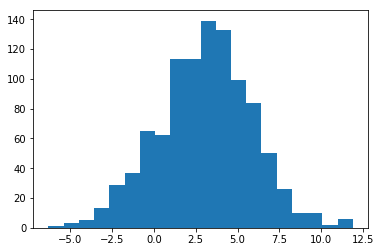

In [12]:
results = np.random.normal(mean, stddev, 1000)
plt.hist(results, bins=20);

In [13]:
(results < 0).mean()

0.14599999999999999

The more samples we take, the less variation we'll see in this number. To demonstrate this, let's plot a histogram of the results for various numbers of samples.

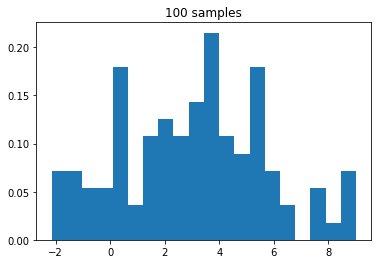

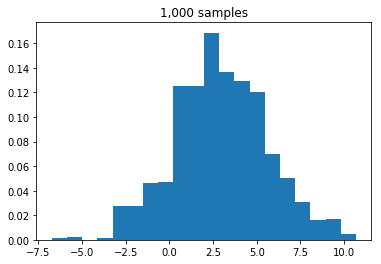

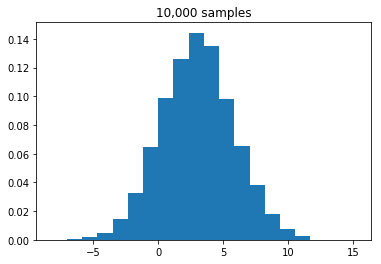

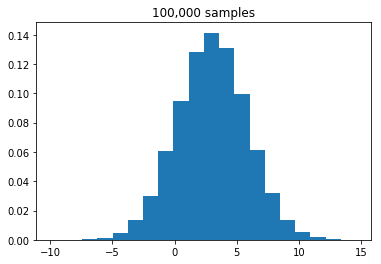

In [14]:
plt.hist(np.random.normal(mean, stddev, 100), bins=20, density=True)
plt.title('100 samples')
plt.show()
plt.hist(np.random.normal(mean, stddev, 1000), bins=20, density=True)
plt.title('1,000 samples')
plt.show()
plt.hist(np.random.normal(mean, stddev, 10000), bins=20, density=True)
plt.title('10,000 samples')
plt.show()
plt.hist(np.random.normal(mean, stddev, 100000), bins=20, density=True)
plt.title('100,000 samples')
plt.show()

We can get a reliable win percentage by counting the wins in a large sample:

## Part 2: The Electoral college
This shows how to interpret the uncertainty in a single poll -- at least the uncertainty in the margin of error. There are two major directions to go from here:

1) In a real election prediction model, we would combine all the polls according to a weighted average of poll reliability. What "reliability" really means is how well the poll matched (predicted) previous election results. We can figure out the optimal combination of poll weights using, for example, linear regression.

2) The US uses an electoral college system, where each state contributes a fixed number of votes (out of a total of 538). We definitely need to simulate that to get anything like a reasonable election prediction.

So for the next step, let's see how to combine polls in the electoral college.

Our first task will be to pick out one poll in each state. We'll use the last dated "Likely Voter" poll.

In [41]:
# Load a CSV of electoral college votes for each state. 
# Ref: https://www.archives.gov/federal-register/electoral-college/allocation.html
states = pd.read_csv('data/states.csv')


In [43]:
# We'll use a little Pandas trick to make merging in the poll data easier: 
# set the index to the abbreviation
states = states.set_index(states.abbr)

# And add the columns we'll need: Trump, Clinton, margin_of_error, all initially blank
states['Trump'] = np.NaN
states['Clinton'] = np.NaN
states['margin_of_error'] = np.NaN

states = states[states.abbr != 'DC']

,name,abbr,electoral_votes,Trump,Clinton,margin_of_error
abbr,,,,,,
AL,Alabama,AL,9,NaN,NaN,NaN
AK,Alaska,AK,3,NaN,NaN,NaN
AZ,Arizona,AZ,11,NaN,NaN,NaN
AR,Arkansas,AR,6,NaN,NaN,NaN
CA,California,CA,55,NaN,NaN,NaN
CO,Colorado,CO,9,NaN,NaN,NaN
CT,Connecticut,CT,7,NaN,NaN,NaN
DE,Delaware,DE,3,NaN,NaN,NaN
FL,Florida,FL,29,NaN,NaN,NaN


In [37]:
# Not all polls have reported margins of error, but we can figure it out if we know the number of people surveyed.
# This function salculate the 95% margin of error, using the classic formula. 
# Ref: https://onlinecourses.science.psu.edu/stat100/node/56/
def calc_moe(sample_size, proportion):
    return 100 * 1.96 * math.sqrt((proportion*(1-proportion)/sample_size))

In [47]:
# Now we'll load polls for each state and pick one poll
for abbr in states.abbr: 
    polls = pd.read_csv('data/' + abbr + '.tsv', sep='\t')
    polls = polls[polls.sample_subpopulation == 'Likely Voters']
    poll = polls.tail(1).squeeze() 

    states.loc[abbr,'Trump'] = poll.Trump
    states.loc[abbr,'Clinton'] = poll.Clinton

    # There may be no MOE reported for this poll. If not, calculate it
    moe = poll.margin_of_error
    if pd.isnull(moe):
        proportion = poll.Trump / 100  # or Clinton, will give nearly same result 
        moe = calc_moe(poll.observations, proportion)

    states.loc[abbr,'margin_of_error'] = moe

Now we simulate an election by drawing a sample from each state election indpendently, then tallying the electoral college votes. Instead of looking at the distribution of Clinton-Trump vote, we'll just look at the distribution of EC votes for Clinton.

In [62]:
def simulate_election(n_times):
    # Start with 3 votes for DC (for which we have no polls, but went solidly Clinton)        
    clinton_ec_votes = np.zeros(n_times) + 3 
    
    # run n_times simulated 'elections' for each state
    for abbr in states.abbr:
        mean = states['Clinton'][abbr] - states['Trump'][abbr]
        stddev = states['margin_of_error'][abbr]
        
        results = np.random.normal(mean, stddev, n_times)
        
        # Add ec votes for every election where Clinton won this state
        clinton_ec_votes[results>0] += states['electoral_votes'][abbr]
    
    return clinton_ec_votes

In [63]:
# Run 10 simulated elections and look at the results
simulate_election(10)

array([ 365.,  293.,  339.,  302.,  312.,  373.,  287.,  284.,  296.,  312.])

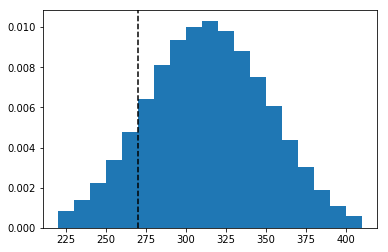

In [64]:
# Run many, many simulated elections and plot histogram of results
results = simulate_election(100000)
plt.hist(results, bins=range(220, 420, 10), density=True)
plt.axvline(270, color='black', linestyle='dashed');

To get a Clinton win probability out of this, we can calculate the percentage where she receives 270 or more.

In [65]:
(results >= 270).mean()

0.86687999999999998

## Part 3: Correlated errors

In [66]:
# Let's start with some random numbers
mean=0
stddev=1
n=10
np.random.normal(mean, stddev, n)

array([ 0.46343466,  0.42504052, -2.13544195,  0.62857464,  1.41485492,
        0.5109058 ,  1.4126031 ,  0.2540728 , -1.16216505, -0.68903853])

In [83]:
# Sum of these random numbers
np.random.normal(mean, stddev, n).sum()

2.7225077557749442

In [84]:
def plot_distribution_of_sums(make_a_sum_function, n_times):
    sums = pd.DataFrame(np.zeros(n_times))
    sums = sums.applymap(make_a_sum_function)
    sums.plot(kind='hist', bins=20)
    print("standard deviation")
    print(float(sums.std()))
    

standard deviation
3.176459754571901


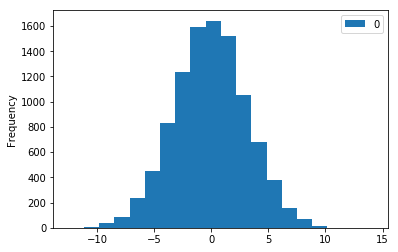

In [85]:
# If take the sum of these random numbers 1000 times, what do we get?
def uncorrelated_sum(dummy):
    return np.random.normal(mean, stddev, n).sum()
plot_distribution_of_sums(uncorrelated_sum, 10000)

But suppose that half of these random numbers were actually the *same* random number...

In [86]:
def correlated_randoms():
    numbers = np.random.normal(mean, stddev, n)
    numbers[6:10] = numbers[5]
    return numbers

In [95]:
correlated_randoms()

array([ 0.90525753, -1.51209138, -0.27435613, -0.97697513, -0.26884543,
       -0.49968656, -0.49968656, -0.49968656, -0.49968656, -0.49968656])

standard deviation
5.461282773904414


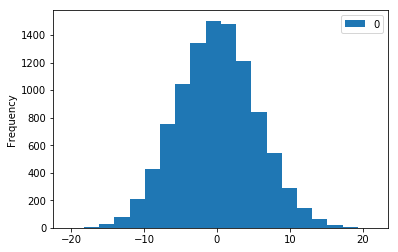

In [96]:
def correlated_sum(dummmy):
    return correlated_randoms().sum()
plot_distribution_of_sums(correlated_sum, 10000)

## Part 4: Elections with correlated errors

A poll is meant to tell us how people will vote in an election. But there will be some difference between the last latest polls before an election and the actual election results. According to [this research](http://www.stat.columbia.edu/~gelman/research/unpublished/polling-errors.pdf), US state level presidentail polls in the last three weeks before an election are off by an average of 2%.

So we could simply add 2% to our margins of error. But this isn't quite right: when a poll is off in one state, it's often off in other states for similar reasons. The polling error is *correlated.* Not taking into account correlated polling errors were the [biggest reason](https://fivethirtyeight.com/features/election-update-why-our-model-is-more-bullish-than-others-on-trump/) that many 2016 election predictions were so badly off.

First, let's see what simply doubling the margin of error on every state does. This increases error, but not *correlated* error.

In [99]:
# Helper function to interpret results
def plot_results(results):
    plt.hist(results, bins=range(150, 500, 10), density=True)
    plt.axvline(270, color='black', linestyle='dashed');
    print("Clinton win probability: " + str((results>=270).mean()))

Instead, we need to add polling error that is similar between states. The simplest way to do this is just to add the same polling error to every state (perfectly correlated across all states!)

In [97]:
def simulate_election_national_error(n_times, polling_error_stddev):
    # Start with 3 votes for DC (for which we have no polls, but went solidly Clinton)        
    clinton_ec_votes = np.zeros(n_times) + 3 
    
    # For each "election", add in the same random polling error for every state
    polling_errors = np.random.normal(0, polling_error_stddev, n_times)
    
    # run n_times simulated 'elections' for each state
    for abbr in states.abbr:
        mean = states['Clinton'][abbr] - states['Trump'][abbr]
        stddev = states['margin_of_error'][abbr]
        
        results = np.random.normal(mean, stddev, n_times)
        
        results += polling_errors
        
        # Add ec votes for every election where Clinton won this state
        clinton_ec_votes[results>0] += states['electoral_votes'][abbr]
    
    return clinton_ec_votes

Clinton win probability: 0.95885


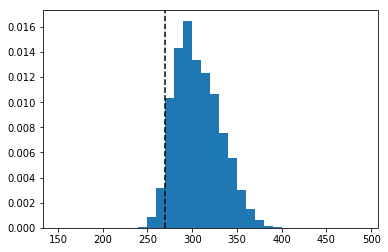

In [105]:
# What does the distribution of electoral college outcomes look like with 2% correlated national polling error?
national_polling_error_stddev = 0
results = simulate_election_national_error(100000, national_polling_error_stddev)
plot_results(results)

In [106]:
(results > 270).mean()

0.95176000000000005